In [462]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

import prettytable as pt

In [463]:
def load_data():
    path = "./data/agaricus-lepiota.data"
    df = pd.read_fwf(path, header = None)
    df = df[0].str.split(',',expand = True)
    bad = df.isin(['?']).any()
    for i in range(23):
        if bad[i] == True:
            df = df.drop([i], axis = 1)
    return df

In [464]:
def getCount(indeices, freq_target):
    count = dict()

    for index in indeices:
        count[index] = 0
        
    for index in freq_target.index.tolist():
        count[index] = freq_target[index]
        
    return count

In [465]:
def draw(df):
    features = ["", "cap-shape", "cap-surface", "cap-color", "bruises?", "odor", "gill-attachment", "gill-spacing", "gill-size", "gill-color", "stalk-shape", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", "ring-type", "spore-print-color", "population", "habitat"]
    colors = ['red', 'green', 'blue', 'pink', 'black']
    
    for i in range(1, 23, 1):
        if i == 11:
            continue
            
        print("Feature {}:".format(i))
        freq = df[i].value_counts()
        
        if features[i] == "veil-type":
            add = pd.Series([0], index=['u'])
            freq = freq.append(add)
            
        count = freq.to_dict()

        plt.bar(*zip(*count.items()), color = colors[i % len(colors)], label = features[i])
        plt.title("Value Count (Total)")
        plt.legend()
        plt.show()
        
        indeices = freq.index.tolist()
        
        df_e = df[(df[0] == 'e')]
        freq_e = df_e[i].value_counts()
        e_count = getCount(indeices, freq_e)
        plt.bar(*zip(*e_count.items()), color = colors[i % len(colors)], label = features[i])
        plt.title("Value Count (Label is 'e')")
        plt.legend()
        plt.show()
        
        df_p = df[(df[0] == 'p')]
        freq_p = df_p[i].value_counts()
        p_count = getCount(indeices, freq_p)
        plt.bar(*zip(*p_count.items()), color = colors[i % len(colors)], label = features[i])
        plt.title("Value Count (Label is 'p')")
        plt.legend()
        plt.show()

In [466]:
def label_encoding(y):
    labelencoder = LabelEncoder()
    y = labelencoder.fit_transform(y)
    return y

In [467]:
def with_Laplace_smoothing(X_train, X_test, y_train, y_test):
    model = MultinomialNB()
    model.fit(X_train, y_train)
    return model

In [468]:
def without_Laplace_smoothing(X_train, X_test, y_train, y_test):
    model = MultinomialNB(alpha = 1.0e-10)
    model.fit(X_train, y_train)
    return model

In [469]:
def holdout_validation(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) 
    
    with_L_model = with_Laplace_smoothing(X_train, X_test, y_train, y_test)
    with_L_y_pred = with_L_model.predict(X_test)
    with_L_c_m = confusion_matrix(y_test, with_L_y_pred)
    with_L_a_s = accuracy_score(y_test, with_L_y_pred) 
    with_L_r_s = recall_score(y_test, with_L_y_pred, average = 'binary')
    with_L_p_s = precision_score(y_test, with_L_y_pred, average = 'binary')
    h_with_L_list = ["Holdout with Smoothing", with_L_c_m, with_L_a_s, with_L_r_s, with_L_p_s]
    
    without_L_model = without_Laplace_smoothing(X_train, X_test, y_train, y_test)
    without_L_y_pred = without_L_model.predict(X_test)
    without_L_c_m = confusion_matrix(y_test, without_L_y_pred)
    without_L_a_s = accuracy_score(y_test, without_L_y_pred) 
    without_L_r_s = recall_score(y_test, without_L_y_pred, average = 'binary')
    without_L_p_s = precision_score(y_test, without_L_y_pred, average = 'binary')
    h_without_L_list = ["Holdout without Smoothing", without_L_c_m, without_L_a_s, without_L_r_s, without_L_p_s]
    return h_with_L_list, h_without_L_list

In [470]:
def k_fold(X, y):
    k = 3
    kf = KFold(n_splits = k)
    
    total_with_L_c_m, total_with_L_a_s, total_with_L_r_s, total_with_L_p_s = np.array([[0, 0], [0, 0]]), np.array([]), np.array([]), np.array([])
    total_without_L_c_m, total_without_L_a_s, total_without_L_r_s, total_without_L_p_s = np.array([[0, 0], [0, 0]]), np.array([]), np.array([]), np.array([])

    for train_index, test_index in kf.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        
        with_L_model = with_Laplace_smoothing(X_train, X_test, y_train, y_test)
        with_L_y_pred = with_L_model.predict(X_test)
        with_L_c_m = confusion_matrix(y_test, with_L_y_pred)
        with_L_a_s = accuracy_score(y_test, with_L_y_pred) 
        with_L_r_s = recall_score(y_test, with_L_y_pred, average = 'binary')
        with_L_p_s = precision_score(y_test, with_L_y_pred, average = 'binary')
        total_with_L_c_m = total_with_L_c_m + with_L_c_m
        total_with_L_a_s = np.append(total_with_L_a_s, with_L_a_s)
        total_with_L_r_s = np.append(total_with_L_r_s, with_L_r_s)
        total_with_L_p_s = np.append(total_with_L_p_s, with_L_p_s)
        
        without_L_model = without_Laplace_smoothing(X_train, X_test, y_train, y_test)
        without_L_y_pred = without_L_model.predict(X_test)
        without_L_c_m = confusion_matrix(y_test, without_L_y_pred)
        without_L_a_s = accuracy_score(y_test, without_L_y_pred) 
        without_L_r_s = recall_score(y_test, without_L_y_pred, average = 'binary')
        without_L_p_s = precision_score(y_test, without_L_y_pred, average = 'binary')
        total_without_L_c_m = total_without_L_c_m + with_L_c_m
        total_without_L_a_s = np.append(total_without_L_a_s, without_L_a_s)
        total_without_L_r_s = np.append(total_without_L_r_s, without_L_r_s)
        total_without_L_p_s = np.append(total_without_L_p_s, without_L_p_s)
        
    avg_with_L_c_m = total_with_L_c_m / k
    avg_with_L_a_s = np.mean(total_with_L_a_s)
    avg_with_L_r_s = np.mean(total_with_L_r_s)
    avg_with_L_p_s = np.mean(total_with_L_p_s)

    avg_without_L_c_m = total_without_L_c_m / k
    avg_without_L_a_s = np.mean(total_without_L_a_s)
    avg_without_L_r_s = np.mean(total_without_L_r_s)
    avg_without_L_p_s = np.mean(total_without_L_p_s)
    
    k_with_L_list = ["K-fold with Smoothing", avg_with_L_c_m, avg_with_L_a_s, avg_with_L_r_s, avg_with_L_p_s]
    k_without_L_list = ["K-fold without Smoothing", avg_without_L_c_m, avg_without_L_a_s, avg_without_L_r_s, avg_without_L_p_s]

    return k_with_L_list, k_without_L_list

In [471]:
def get_n2(count):
    n2 = 0
    for key in count:
        n2 = n2 + count[key]
    return n2

In [472]:
def smoothing(freq):
    probability = dict()
    count = freq.to_dict()
    n2 = get_n2(count)
    k = 500
    m = 2
    for key in count:
        n1 = count[key]
        p = (n1 + k) / (n2 + k * m)
        probability[key] = p
    
    return pd.Series(probability)
    

In [473]:
def draw_question(df):
    X = df[(df[0] == 'e')]
    freq = X[15].value_counts()
    
    index = np.arange(len(freq))
    bar_width = 0.35

    labels = list(freq.to_dict().keys())
    
    fig, ax = plt.subplots()
    
    without_L_s_probability = X[15].value_counts(normalize = True)
    ax.bar(index, without_L_s_probability, bar_width, label = "without smoothing")
    
    with_L_s_probability = smoothing(freq)
    ax.bar(index + bar_width, with_L_s_probability, bar_width, label = "with smoothing")
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(labels)
    plt.legend()
    plt.show()
    return

In [474]:
df = load_data()
df = shuffle(df) #index也洗了（在data裡一定有至少一筆相同的資料，但index不一定是原本的index）
X = df.drop(columns=[0]) #把feature提取出來
y = df[0] #label 
X = pd.get_dummies(X) #onehot encoding
y = label_encoding(y) #already array type
X = X.to_numpy() #to array type

h_with_L_list, h_without_L_list = holdout_validation(X, y)
k_with_L_list, k_without_L_list = k_fold(X, y)

table = pt.PrettyTable()
table.field_names = ["Method", "Confusion Matrix", "Accuracy", "Sensitivity(Recall)", "Precision"]
table.add_row(h_with_L_list)
table.add_row(h_without_L_list)
table.add_row(k_with_L_list)
table.add_row(k_without_L_list)

print(table)

+---------------------------+---------------------------------+--------------------+---------------------+--------------------+
|           Method          |         Confusion Matrix        |      Accuracy      | Sensitivity(Recall) |     Precision      |
+---------------------------+---------------------------------+--------------------+---------------------+--------------------+
|   Holdout with Smoothing  |           [[1256   10]          | 0.9655455291222313 |  0.9368600682593856 | 0.9909747292418772 |
|                           |           [  74 1098]]          |                    |                     |                    |
| Holdout without Smoothing |           [[1256   10]          | 0.9958982772764561 |         1.0         | 0.9915397631133672 |
|                           |           [   0 1172]]          |                    |                     |                    |
|   K-fold with Smoothing   |  [[1395.33333333    7.33333333] | 0.9588872476612506 |  0.9203413344258021

Feature 1:


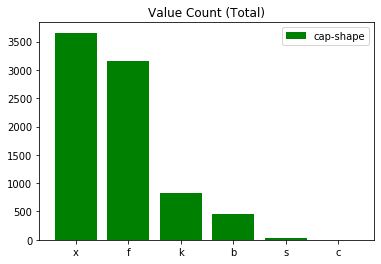

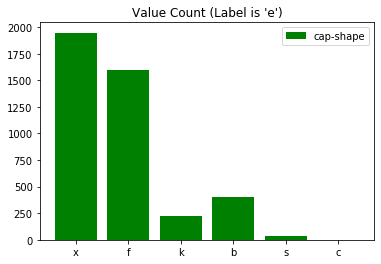

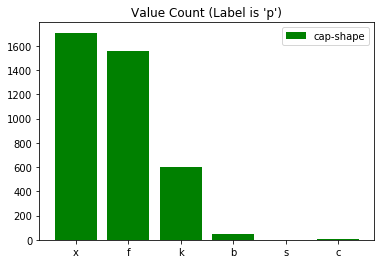

Feature 2:


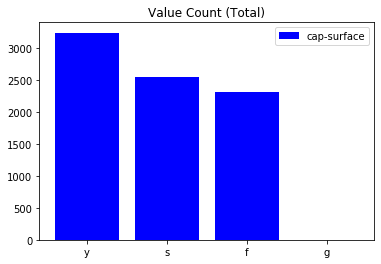

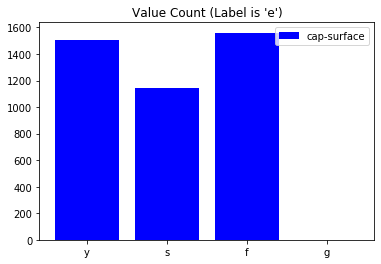

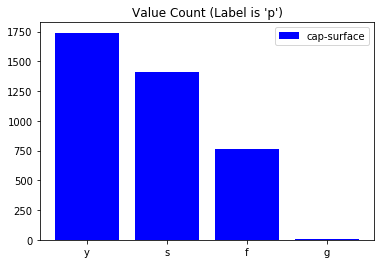

Feature 3:


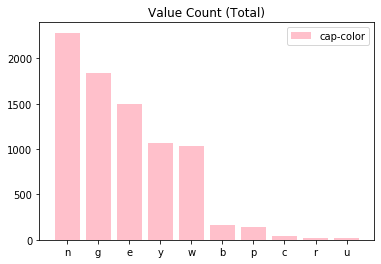

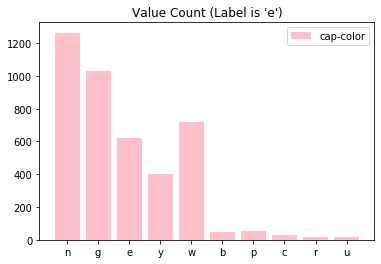

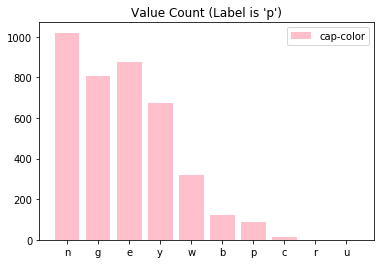

Feature 4:


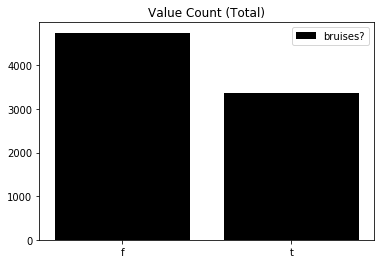

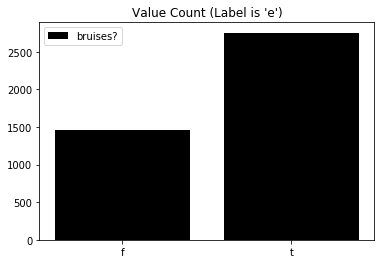

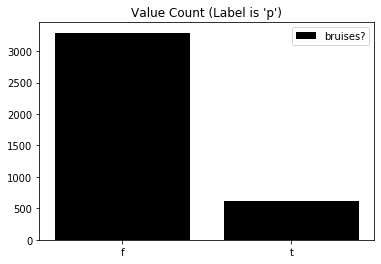

Feature 5:


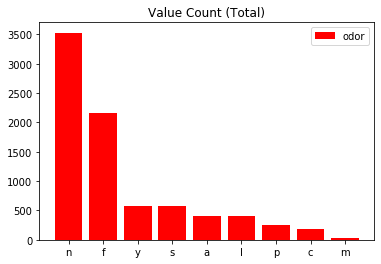

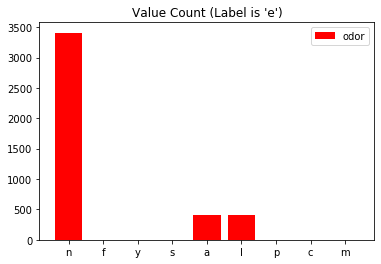

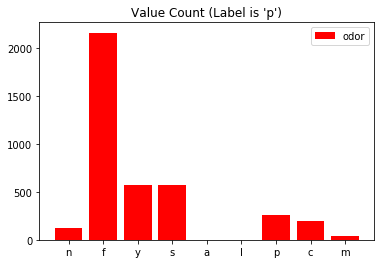

Feature 6:


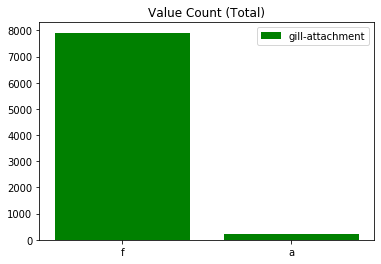

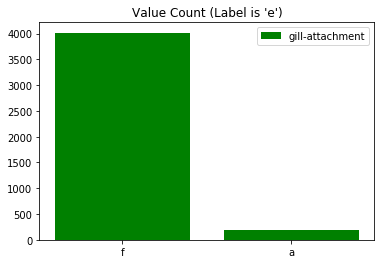

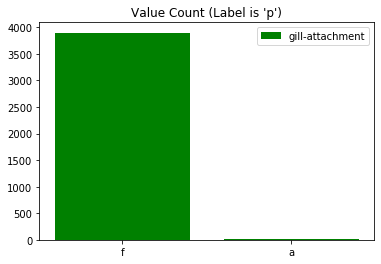

Feature 7:


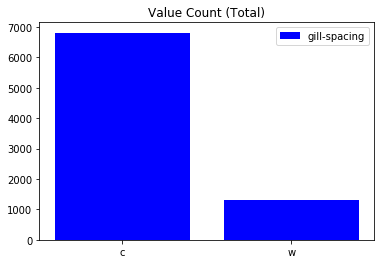

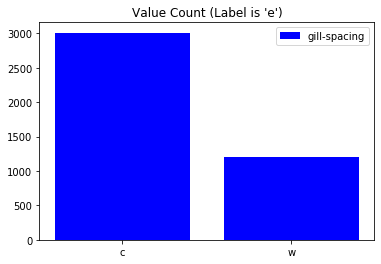

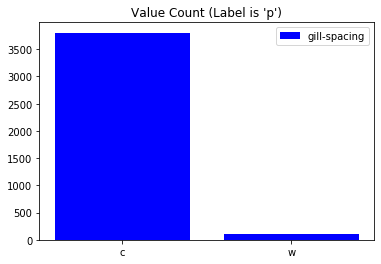

Feature 8:


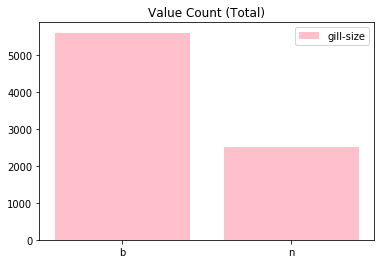

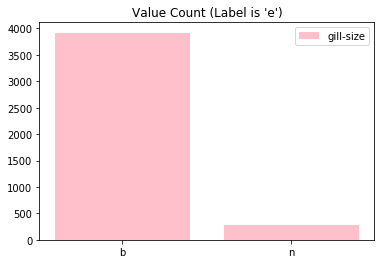

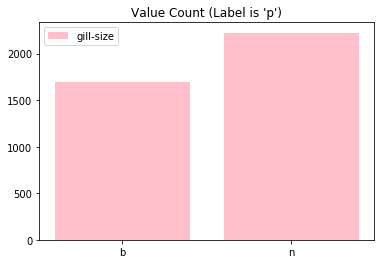

Feature 9:


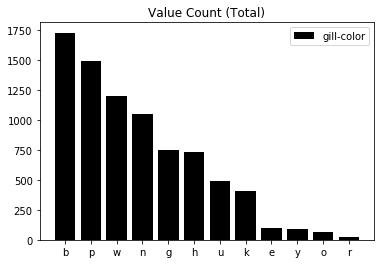

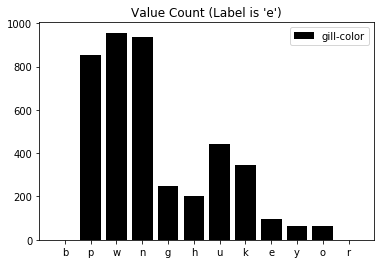

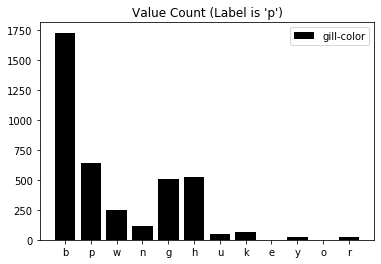

Feature 10:


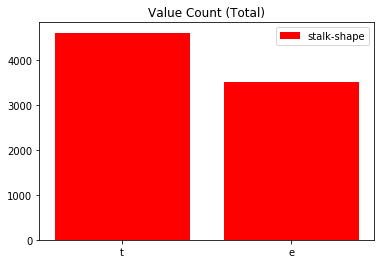

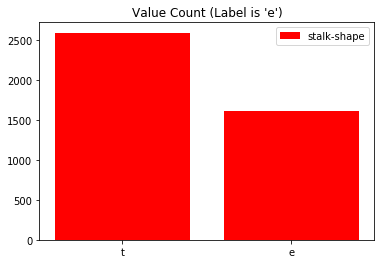

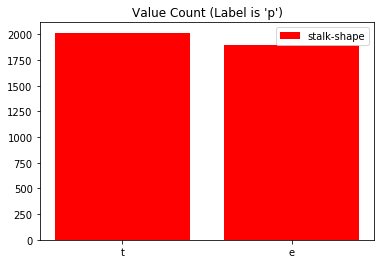

Feature 12:


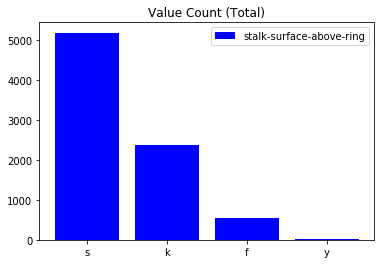

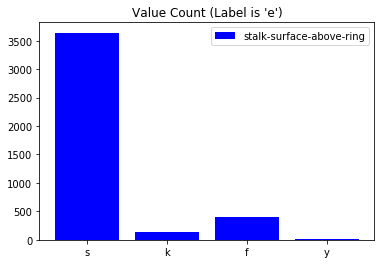

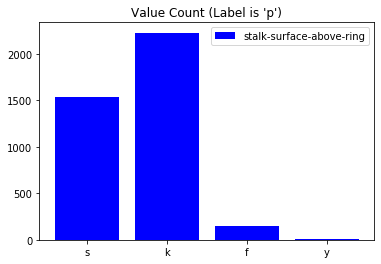

Feature 13:


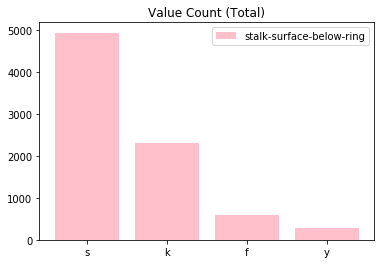

In [ ]:
draw(df)

In [ ]:
draw_question(df)